# Detecting Obfuscated JavaScript

## Import required libraries

In [1]:
import os
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare files

In [2]:
# Define paths to two sets of JavaScript samples
# One for normal JavaScript files, one for obfuscated JavaScript files
js_path = "JavascriptSamples"                   # Label: 0
obfuscated_js_path = "JavascriptSamplesObfuscated"  # Label: 1

# Lists to store the text content and their corresponding labels
corpus = []
labels = []

# Tuple of (directory path, associated label)
file_types_and_labels = [(js_path, 0), (obfuscated_js_path, 1)]

## Read files

In [3]:
# Iterate through each directory and collect data
for files_path, label in file_types_and_labels:
    files = os.listdir(files_path)  # List all files in the directory
    for file in files:
        file_path = files_path + "/" + file
        try:
            # Open and read each file
            with open(file_path, "r") as myfile:
                data = myfile.read().replace("\n", "")  # Remove newlines
                data = str(data)  # Ensure data is string
                corpus.append(data)  # Add content to corpus
                labels.append(label)  # Add corresponding label (0 or 1)
        except:
            pass  # Skip files that cause errors (e.g., unreadable)

## Train-test split

In [4]:
# Split the dataset into training and test sets (67% train, 33% test)
X_train, X_test, y_train, y_test = train_test_split(
    corpus, labels, test_size=0.33, random_state=42
)

## Create a machine learning pipeline

In [5]:
text_clf = Pipeline(
    [
        # Convert raw text into hashed n-gram feature vectors (1-grams to 3-grams)
        ("vect", HashingVectorizer(input="content", ngram_range=(1, 3))),
        
        # Apply TF-IDF weighting to the vectors
        ("tfidf", TfidfTransformer(use_idf=True)),
        
        # Use Random Forest classifier with balanced class weights
        ("rf", RandomForestClassifier(class_weight="balanced")),
    ]
)

## Train the model

In [6]:
# Train the pipeline on the training data
text_clf.fit(X_train, y_train)

# Predict labels for the test set
y_test_pred = text_clf.predict(X_test)

# Print out the accuracy and confusion matrix to evaluate performance
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

0.9658886894075404
[[613  22]
 [ 16 463]]


## List all hyperparameters of the pipeline

In [7]:
from pprint import pprint

pprint(text_clf.get_params())

{'memory': None,
 'rf': RandomForestClassifier(class_weight='balanced'),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__monotonic_cst': None,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False,
 'steps': [('vect', HashingVectorizer(ngram_range=(1, 3))),
           ('tfidf', TfidfTransformer()),
           ('rf', RandomForestClassifier(class_weight='balanced'))],
 'tfidf': TfidfTransformer(),
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'transform_input': None,
 'vect': HashingVectorizer(ngram_range=(1, 3)),
 'vect__alternate_sign': True,

# Visualisation

## Confusion matrix

<Figure size 600x600 with 0 Axes>

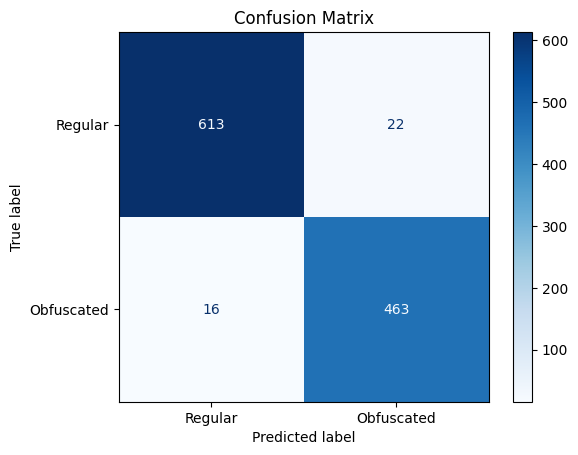

In [8]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Regular', 'Obfuscated'])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## Accuracy

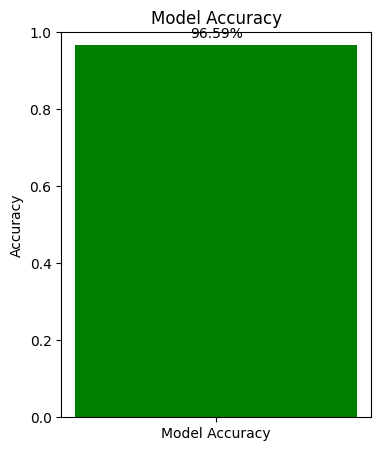

In [9]:
acc = accuracy_score(y_test, y_test_pred)

# Bar chart of accuracy
plt.figure(figsize=(4, 5))
plt.bar(["Model Accuracy"], [acc], color='green')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.text(0, acc + 0.02, f"{acc:.2%}", ha='center')
plt.show()

## Feature importances

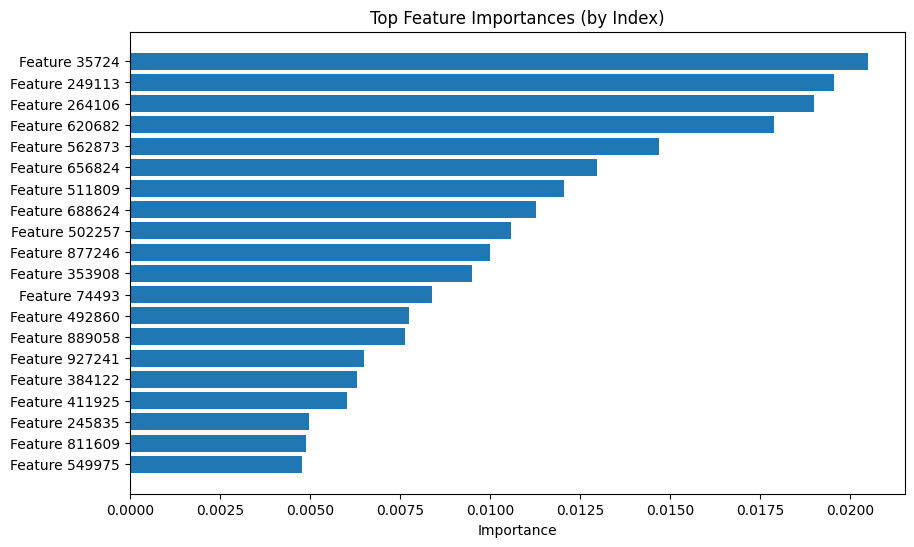

In [10]:
importances = text_clf.named_steps['rf'].feature_importances_

# Visualize top N importances (just as index positions)
import numpy as np

top_n = 20
indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices])
plt.yticks(range(top_n), [f'Feature {i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top Feature Importances (by Index)')
plt.show()